# LAB 2
In this lab, we start with the 1D Poisson problem, and solve it by **FINITE ELEMENTS** using FIREDRAKE.

In [ ]:
# Installation of firedrake
try:
  import firedrake
except ImportError:
  !wget "https://fem-on-colab.github.io/releases/firedrake-install-real.sh" -O "/tmp/firedrake-install.sh" && bash "/tmp/firedrake-install.sh"
  import firedrak

In [ ]:
import firedrake as fd
import numpy as np
import firedrake.pyplot as fdplt
import matplotlib.pyplot as plt

## EXERCISE 1:

Consider problem
$$
\begin{cases}
-u'' = f & \text{in $(0, 1)$} \\
u(0) = u(1) = 0
\end{cases}
$$
with
$$
f = \sin(2 \pi x),
$$
so that the exact solution is
$$
u = \dfrac{1}{4 \pi^2} \sin(2 \pi x).
$$

(a) Solve the problem using Firedrake and $P^1$ elements. \\
(b) Verify the convergence rate. Try increasing the order of the finite element spaces used $(P^2, P^3, ...)$.

### (a) Solve the problem using Firedrake and $P^1$ elements.

The types of finite elements available in Firedrake are listed in https://firedrakeproject.org/variational-problems.html#supported-finite-elements.

In [ ]:
# Number of division
N = 20

# Here we don't need to specify the interval extrema becaus there is a comand
# on Firedrake that makes automatically the mesh by itself between (0, 1)

In [ ]:
def solve_FE(N):
  '''
  Solves Poissons eq. on [0, 1], with N grid points and forcing term g(x) using
  Finite Elements method for P1 order polinomial
  '''
  # Build the mesh
  mesh = fd.UnitIntervalMesh(N) # This is alredy in (0, 1)
  x = fd.SpatialCoordinate(mesh) # Give a name to the coordinates in the mesh

  # Define a discrete function space V
  V = fd.FunctionSpace(mesh, 'Lagrange', 1) # Define the finite space V to which belongs
                                            # u and v as the Lagrange polinomial of
                                            # degree 1 in the domain defined by the
                                            # mesh


  # Define trial and test functions as belonging to the space
  u = fd.TrialFunction(V) # Trial function
  v = fd.TestFunction(V) # Test function


  # Define the boundary condition (in our case homogeneous Dirichlet)
  bc = fd.DirichletBC(V, fd.Constant(0.), "on_boundary") # on_boundary is a keyword to set boundary conditions on all boundaries


  # Define the function of your problem
  f = fd.sin(2*np.pi*x[0]) # Use it to define the function as an UFL expression



  # Define the variational problem
  a = fd.dot(fd.grad(u), fd.grad(v)) * fd.dx # Bilinear form
  L = f*v*fd.dx # Linear function

  # fd.dx automatically chooses a quadrature scheme by estimating
  # the required degree of exactness. We can also impose the
  # degree by writing, for example, fd.dx(degree=2)

  # As you can see, we are writing fd quite a lot of times...
  # From the next time, we will import all of Firedrake using
  # from firedrake import *


  # Solve the problem:
  u_h = fd.Function(V) # Define the solution as belonging to the space V
  fd.solve(a == L, u_h, bc)

  return u_h, mesh, x

We have two choices for plotting the exact solution:
 - define it as an ufl expression and project it on a finer mesh, or on a higher degree basis on the same mesh, and plot using Firedrake;
 - define it as a lambda function and plot using matplotlib.

In [ ]:
# Get the approximate solution
u_h, mesh, x = solve_FE(N)

In [ ]:
# Define the exact solution
u_ex = 1/(4*np.pi**2) * fd.sin(2*np.pi*x[0]) # Exact solution (given by the problem)
V3 = fd.FunctionSpace(mesh, 'Lagrange', 3) # Set the space for the exact solution plot

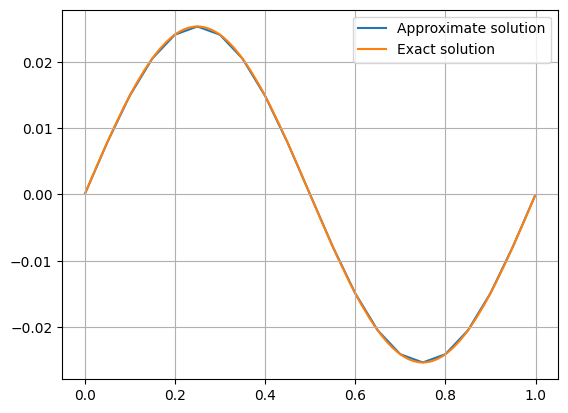

In [ ]:
# Plot the results:
fig, ax = plt.subplots()
fdplt.plot(u_h, axes=ax, color='b', label='Approximate solution')
fdplt.plot(fd.project(u_ex, V3), axes=ax, color='r', label='Exact solution')
ax.legend()
ax.grid()

### (b) Verify the convergence rate. Try increasing the order of the finite element spaces used $(P^2, P^3, ...)$.

In [ ]:
# Set number of points:
N = 20


In [ ]:
def solve_FE_recorsive(N, P):
  '''
  Solves Poissons eq. on [0, 1], with N grid points and forcing term g(x) using
  Finite Elements method for P-order polinomial
  '''
  # Build the mesh
  mesh = fd.UnitIntervalMesh(N) # This is alredy in (0, 1)
  x = fd.SpatialCoordinate(mesh) # Give a name to the coordinates in the mesh

  # Define a discrete function space V
  V = fd.FunctionSpace(mesh, 'Lagrange', P) # Define the finite space V to which belongs
                                            # u and v as the Lagrange polinomial of
                                            # degree 1 in the domain defined by the
                                            # mesh


  # Define trial and test functions as belonging to the space
  u = fd.TrialFunction(V) # Trial function
  v = fd.TestFunction(V) # Test function


  # Define the boundary condition (in our case homogeneous Dirichlet)
  bc = fd.DirichletBC(V, fd.Constant(0.), "on_boundary") # on_boundary is a keyword to set boundary conditions on all boundaries


  # Define the function of your problem
  f = fd.sin(2*np.pi*x[0]) # Use it to define the function as an UFL expression



  # Define the variational problem
  a = fd.dot(fd.grad(u), fd.grad(v)) * fd.dx # Bilinear form
  L = f*v*fd.dx # Linear function

  # fd.dx automatically chooses a quadrature scheme by estimating
  # the required degree of exactness. We can also impose the
  # degree by writing, for example, fd.dx(degree=2)

  # As you can see, we are writing fd quite a lot of times...
  # From the next time, we will import all of Firedrake using
  # from firedrake import *


  # Solve the problem:
  u_h = fd.Function(V) # Define the solution as belonging to the space V
  fd.solve(a == L, u_h, bc)


  # Compute errors;
  u_ex = 1/(4*np.pi**2) * fd.sin(2*np.pi*x[0])# Exact solution:
  err_H1 = fd.errornorm(u_ex, u_h, norm_type='H1')
  err_L2 = fd.errornorm(u_ex, u_h, norm_type='L2')

  return u_h, err_H1, err_L2

In [ ]:
# Define array of polynomial orders
P = np.array((1, 2, 3, 4, 5, 6, 7))

# Initialize arry of errors
err_H1_vec = []
err_L2_vec = []

for ii in range(len(P)):
  u_h, err_H1, err_L2 = solve_FE_recorsive(N, int(P[ii]))
  err_H1_vec.append(err_H1)
  err_L2_vec.append(err_L2)

NameError: name 'np' is not defined

In [ ]:
# Plot errors
fig, ax = plt.subplots()
ax.loglog(P, err_H1_vec, '*', label='FEM')
ax.loglog(P, 1e-1*1/P, '--', label='$Order 1$')
ax.loglog(P, 1e-1*1/P**2, '--', label='$Order 2$')
ax.loglog(P, 1e-1*1/P**3, '--', label='$Order 3$')
ax.loglog(P, 1e-1*1/P**4, '--', label='$Order 4$')
ax.grid(which='minor')
ax.set_title('$H^1$ error')
ax.legend()

fig, ax = plt.subplots()
ax.loglog(P, err_L2_vec, '*', label='FEM')
ax.loglog(P, 1e-2*1/P**2, '--', label='$P^{-2}$')
ax.grid(which='minor')
ax.set_title('$L^2$ error')
ax.legend()

## EXERCISE 2
Prove that the $1D$ finite element method with $P1$ elements and trapezoidal integration for the right hand side coincides with the finite difference method for the Poisson problem with Dirichlet conditions.

### Solution:

The right hand side for FE is built element by element. We only consider interior nodes, since Dirichlet conditions fix the first and last elements of the RHS vector, corresponding to the endpoints of the interval.
$$
\begin{split}
b_i &= \int_0^1 f(x) \varphi_i(x) dx = \int_{x_{i-1}}^{x_i} f(x) \varphi_i(x) dx + \int_{x_i}^{x_{i+1}} f(x) \varphi_i(x) dx \\
& \approx \frac{h}{2} [f(x_{i-1})\underbrace{\varphi_i(x_{i-1})}_{=0} + f(x_{i})\underbrace{\varphi_i(x_{i})}_{=1}] + \frac{h}{2} [f(x_{i})\varphi_i(x_{i}) + f(x_{i+1})\underbrace{\varphi_i(x_{i+1})}_{=0}] \\
&= h f(x_{i})
\end{split}
$$
We have thus proved that with this choice of integration scheme, the FE right hand side is equal to the FD right hand side (up to a factor $h$). In the following code, we verify that Firedrake is using midpoint integration by default.

## EXERCISE 3

Consider problem: \\

$$
\begin{cases}
-u'' = f & \text{in $(0, 1)$} \\
u(0) = u(1) = 0
\end{cases}
$$
with
$$
f = \begin{cases}
1, & x \leq 1/2 \\
0, & x > 1/2
\end{cases}.
$$ \\

Verify that the exact solution is \\

$$
u = \begin{cases}
\frac{3}{8}x - \frac{1}{2} x^2, & x \leq 1/2 \\
\frac{1}{8}(1-x), & x > 1/2
\end{cases}.
$$ \\

Solve the problem using finite elements of increasing degree and check the convergence rate with respect to the number of elements. What do you expect, and what do you observe? Hint: you will need to use the ``fd.conditional`` statement (see https://fenics.readthedocs.io/projects/ufl/en/latest/manual/form_language.html?highlight=conditional#conditional). Notice what happens when using an odd vs an even number of elements (see [Remark 3.2, PDEPAE]).

It is the same as exercise 1, but we just need to change f:

In [ ]:
def solve_FE_recorsive_ex3(N, P):
  '''
  Solves Poissons eq. on [0, 1], with N grid points and forcing term g(x) using
  Finite Elements method for P-order polinomial
  '''
  # Build the mesh
  mesh = fd.UnitIntervalMesh(N) # This is alredy in (0, 1)
  x = fd.SpatialCoordinate(mesh) # Give a name to the coordinates in the mesh

  # Define a discrete function space V
  V = fd.FunctionSpace(mesh, 'Lagrange', P) # Define the finite space V to which belongs
                                            # u and v as the Lagrange polinomial of
                                            # degree 1 in the domain defined by the
                                            # mesh


  # Define trial and test functions as belonging to the space
  u = fd.TrialFunction(V) # Trial function
  v = fd.TestFunction(V) # Test function


  # Define the boundary condition (in our case homogeneous Dirichlet)
  bc = fd.DirichletBC(V, fd.Constant(0.), "on_boundary") # on_boundary is a keyword to set boundary conditions on all boundaries


  # Define the function of your problem
  f = fd.conditional(x[0]<=1/2, 1, 0) # Use it to define the function as an UFL expression



  # Define the variational problem
  a = fd.dot(fd.grad(u), fd.grad(v)) * fd.dx # Bilinear form
  L = f*v*fd.dx # Linear function


  # Solve the problem:
  u_h = fd.Function(V) # Define the solution as belonging to the space V
  fd.solve(a == L, u_h, bc)

  return u_h, mesh

In [ ]:
P = 2 # Degree of the polinomial approx.

#N_vec = np.arange(10, 40, 2) # for even numbers
#N_vec = np.arange(11, 40, 2) # for odd numbers
N_vec = np.arange(10, 40) # all

# Initialize vectors of errors
err_H1_vec = []
err_L2_vec = []

for N in N_vec:
    u_h, mesh = solve_FE_recorsive_ex3(N, P)

    x = fd.SpatialCoordinate(mesh)
    u_ex = fd.conditional(x[0]<1/2,
                      1/(4*np.pi**2) * fd.sin(2*np.pi*x[0]) + 1/(4*np.pi)*x[0],
                      1/(4*np.pi) * (1 - x[0]))
    err_H1_vec.append(fd.errornorm(u_ex, u_h, norm_type='H1'))
    err_L2_vec.append(fd.errornorm(u_ex, u_h, norm_type='L2'))


In [ ]:
#Estimate the order of convergence
p_H1 = (np.log(err_H1_vec[0]) - np.log(err_H1_vec[-1]))/(np.log(N_vec[-1]) - np.log(N_vec[0]))
p_L2 = (np.log(err_L2_vec[0]) - np.log(err_L2_vec[-1]))/(np.log(N_vec[-1]) - np.log(N_vec[0]))
print('Order of convergence in H1 norm = ', p_H1)
print('Order of convergence in L2 norm = ', p_L2)
# Since the solution is in H^2 but not in H^3, we have s=1 in the theorem

Order of convergence in H1 norm =  -0.00012762803423350906
Order of convergence in L2 norm =  -2.293801456561592e-05


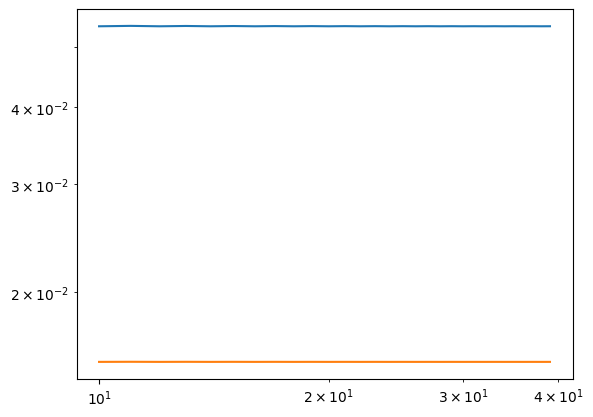

In [ ]:
#Plot of errors:
fig, ax = plt.subplots()
ax.loglog(N_vec, err_H1_vec, label=r'$H^1$')
ax.loglog(N_vec, err_L2_vec, label=r'$L^2$')

## EXERCISE 4

Repeat problem 3 using the forcing term \\
$$
f = \begin{cases}
\sin(2 \pi x), & x \leq 1/2 \\
0, & x > 1/2
\end{cases}.
$$

It is the same as exercise 1, but we just need to change f:

In [ ]:
def solve_FE_recorsive_ex3(N, P):
  '''
  Solves Poissons eq. on [0, 1], with N grid points and forcing term g(x) using
  Finite Elements method for P-order polinomial
  '''
  # Build the mesh
  mesh = fd.UnitIntervalMesh(N) # This is alredy in (0, 1)
  x = fd.SpatialCoordinate(mesh) # Give a name to the coordinates in the mesh

  # Define a discrete function space V
  V = fd.FunctionSpace(mesh, 'Lagrange', P) # Define the finite space V to which belongs
                                            # u and v as the Lagrange polinomial of
                                            # degree 1 in the domain defined by the
                                            # mesh


  # Define trial and test functions as belonging to the space
  u = fd.TrialFunction(V) # Trial function
  v = fd.TestFunction(V) # Test function


  # Define the boundary condition (in our case homogeneous Dirichlet)
  bc = fd.DirichletBC(V, fd.Constant(0.), "on_boundary") # on_boundary is a keyword to set boundary conditions on all boundaries


  # Define the function of your problem
  f = fd.conditional(x[0]<=1/2, fd.sin(2*np.pi*x[0]), 0) # Use it to define the function as an UFL expression



  # Define the variational problem
  a = fd.dot(fd.grad(u), fd.grad(v)) * fd.dx # Bilinear form
  L = f*v*fd.dx # Linear function


  # Solve the problem:
  u_h = fd.Function(V) # Define the solution as belonging to the space V
  fd.solve(a == L, u_h, bc)

  return u_h, mesh

In [ ]:
P = 2 # Degree of the polinomial approx.

#N_vec = np.arange(10, 40, 2) # for even numbers
#N_vec = np.arange(11, 40, 2) # for odd numbers
N_vec = np.arange(10, 40) # all

# Initialize vectors of errors
err_H1_vec = []
err_L2_vec = []

for N in N_vec:
    u_h, mesh = solve_FE_recorsive_ex3(N, P)

    x = fd.SpatialCoordinate(mesh)
    u_ex = fd.conditional(x[0]<1/2,
                      1/(4*np.pi**2) * fd.sin(2*np.pi*x[0]) + 1/(4*np.pi)*x[0],
                      1/(4*np.pi) * (1 - x[0]))
    err_H1_vec.append(fd.errornorm(u_ex, u_h, norm_type='H1'))
    err_L2_vec.append(fd.errornorm(u_ex, u_h, norm_type='L2'))


In [ ]:
#Estimate the order of convergence
p_H1 = (np.log(err_H1_vec[0]) - np.log(err_H1_vec[-1]))/(np.log(N_vec[-1]) - np.log(N_vec[0]))
p_L2 = (np.log(err_L2_vec[0]) - np.log(err_L2_vec[-1]))/(np.log(N_vec[-1]) - np.log(N_vec[0]))
print('Order of convergence in H1 norm = ', p_H1)
print('Order of convergence in L2 norm = ', p_L2)
# Since the solution is in H^2 but not in H^3, we have s=1 in the theorem

Order of convergence in H1 norm =  1.9246221458614845
Order of convergence in L2 norm =  0.402068559999671


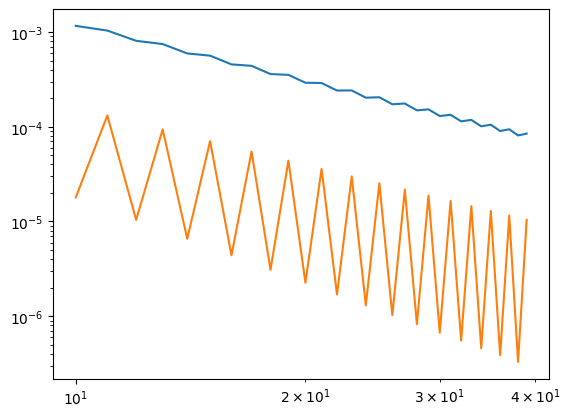

In [ ]:
#Plot of errors:
fig, ax = plt.subplots()
ax.loglog(N_vec, err_H1_vec, label=r'$H^1$')
ax.loglog(N_vec, err_L2_vec, label=r'$L^2$')

## EXERCISE 5

Consider problem
$$
\begin{cases}
-u'' = f & \text{in $(0, 1)$} \\
u(0) = 1 \\
u(1) = 0
\end{cases}
$$
with
$$
f = e^{-x} (x-3),
$$
so that the exact solution is
$$
u = e^{-x}(1-x).
$$ \\

(a) Define a lifting $R(x)$ of the boundary condition to make the problem homogeneous. Compute the solution using firedrake. \\
(b) Compute the solution of the non-homogeneous problem directly using Firedrake.

### (a) Define a lifting $R(x)$ of the boundary condition to make the problem homogeneous. Compute the solution using firedrake.

We can recover a problem with homogeneous conditions by defining the lifting of the boundary condition as a function $R$ defined on the entire domain and satisfying the boundary conditions.
We may take
$$
R = 1-x, \quad u = \tilde{u} + R,
$$
and then solve for $\tilde{u}$ in
$$
\begin{cases}
-\tilde{u}'' = f & \text{in $(0, 1)$} \\
\tilde{u}(0) = \tilde{u}(1) = 0.
\end{cases}
$$ \\

In this way the problem has become homogeneous and we can solve it as usual.

In [ ]:
# To be faster let's just import everything from firedrake:
from firedrake import *

In [ ]:
# Define number of elemenents
N = 20

In [ ]:
# Build the mesh
mesh = UnitIntervalMesh(N)
x = SpatialCoordinate(mesh)[0] # Give a name to the coordinates in the mesh
                               # You add [0] at the end because it is the same
                               # as then recall it inside f or u_ex or wherever
                               # you need to recall it without specify x[0]


# Define a discrete function space V
V = FunctionSpace(mesh, 'Lagrange', 1)


# Define trial and test functions as belonging to the space
u = TrialFunction(V) # Trial function
v = TestFunction(V) # Test function


# Define the boundary condition (in our case homogeneous Dirichlet)
bc = DirichletBC(V, fd.Constant(0.), "on_boundary") # on_boundary is a keyword to set boundary conditions on all boundaries


# Define the function of your problem
f = exp(-x)*(x-3) # Use it to define the function as an UFL expression


# Define the variational problem
a = dot(grad(u), grad(v)) * dx # Bilinear form
L = f*v*dx # Linear function


# Solve the problem:
u_tilde = Function(V) # Define the solution as belonging to the space V
solve(a==L, u_tilde, bcs=bc)


# Reconstruct using the lifting
R = 1 - x # Lifting of the boundary condition
u_h = project(u_tilde + R, V) # We need to interpolate because the two objects are defined in different ways


In [ ]:
# Exact solution:
u_ex = lambda x: np.exp(-x)*(1-x)
x_u_ex = np.linspace(0, 1, 100)


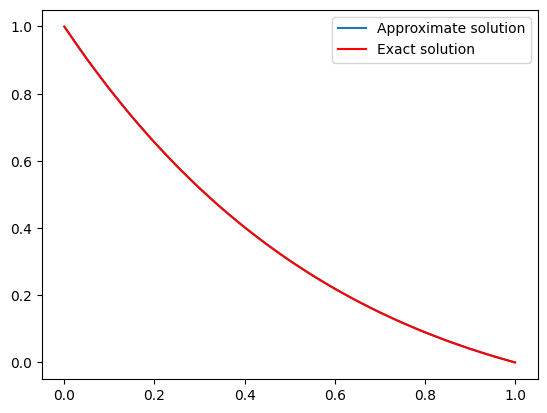

In [ ]:
# Plot the exact VS approximate solution:
fig, ax = plt.subplots()
fdplt.plot(u_h, axes=ax, color='b', label=r'Approximate solution')
ax.plot(x_u_ex, u_ex(x_uex), color='r', label=r'Exact solution')
ax.legend()

### (b) Compute the solution of the non-homogeneous problem directly using Firedrake.


Firedrake can take care of the lifting for us. We just need to specify the non-homogeneous boundary conditions. The procedure is then to build a lifting that belongs to the space of trial functions and that is equal to the boundary condition on boundary nodes and zero in all other mesh nodes. \\

In this case the NON-homogeneous Boundary Condition is $u(0)=1$ and $u(1)=0$, therefore we can say that the BC is a function: \\
$$
g = 1-x
$$

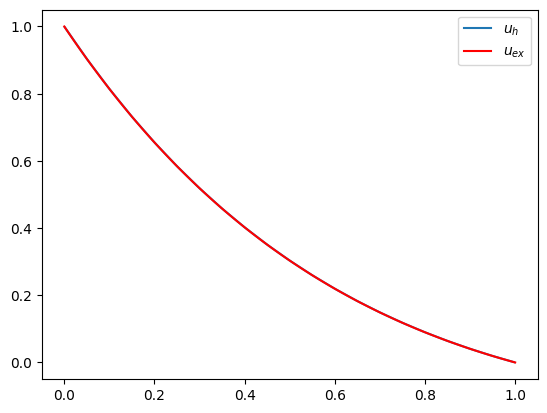

In [ ]:
N = 20
# Build the mesh
mesh = UnitIntervalMesh(N)
x = SpatialCoordinate(mesh)[0] # Give a name to the coordinates in the mesh
                               # You add [0] at the end because it is the same
                               # as then recall it inside f or u_ex or wherever
                               # you need to recall it without specify x[0]


# Define a discrete function space V
V = FunctionSpace(mesh, 'Lagrange', 1)


# Define trial and test functions as belonging to the space
u = TrialFunction(V) # Trial function
v = TestFunction(V) # Test function


# Define the boundary condition (in our case NON-homogeneous Dirichlet)
g = 1 - x
bc = DirichletBC(V, g, "on_boundary") # on_boundary is a keyword to set boundary conditions on all boundaries


# Define the function of your problem
f = exp(-x)*(x-3) # Use it to define the function as an UFL expression


# Define the variational problem
a = dot(grad(u), grad(v)) * dx # Bilinear form
L = f*v*dx # Linear function


# Solve the problem:
u_h = Function(V) # Define the solution as belonging to the space V
solve(a==L, u_h, bcs=bc)


# Reconstruct using the lifting
# R = 1 - x # Lifting of the boundary condition
# u_h = project(u_tilde + R, V) # We need to interpolate because the two objects are defined in different ways


u_ex = lambda x: np.exp(-x)*(1-x)
x_uex = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
fdplt.plot(u_h, axes=ax, color='b', label=r'$u_h$')
ax.plot(x_uex, u_ex(x_uex), color='r', label=r'$u_{ex}$')
ax.legend()


## EXERCISE 6

Consider problem
$$
\begin{cases}
-u'' = f & \text{in $(0, 1)$} \\
u'(0) = g_N\\
u(1) = 0
\end{cases}
$$

Show that, for a finite element discretization with P1 elements and trapezoidal integration, the first equation of the algebraic system is
$$
\dfrac{u_0 - u_1}{h} = -g_N + \dfrac{h}{2} f(x_0).
$$
Using the Taylor series, show that, for smooth functions, this formula has truncation error $\mathcal{O}(h^2)$, in spite of the left hand side looking like a *first* order accurate finite difference formula.